In [6]:
import tensorflow as tf

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available:  0


In [ ]:
pip install keras tensorflow

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [62]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def prepare_dataset(path, batch_size=32):
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2  # Use 20% of data for validation
    )

    train_dataset = datagen.flow_from_directory(
        path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    val_dataset = datagen.flow_from_directory(
        path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_dataset, val_dataset

augmented_data_path = '/content/drive/My Drive/Colab Notebooks/ISLtoText/English Alphabet'
train_dataset, val_dataset = prepare_dataset(augmented_data_path)


Found 549 images belonging to 26 classes.
Found 116 images belonging to 26 classes.


In [49]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the MobileNetV2 model with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Changed input shape to (224, 224, 3)

# Freeze the base model
base_model.trainable = False

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a dense layer (optional)
x = Dense(512, activation='relu')(x)

# Add the final output layer for classification
predictions = Dense(26, activation='softmax')(x)  # Assuming 26 classes

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Ensure labels are one-hot encoded
              metrics=['accuracy'])


print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,927,194 (11.17 MB)

 Trainable params: 669,210 (2.55 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [22]:
class PrintLossCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        print(f"Epoch {epoch + 1}: Training Loss = {train_loss}, Validation Loss = {val_loss}")

# Instantiate the callback
print_loss_callback = PrintLossCallback()

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define a callback to save model checkpoints
checkpoint_callback = ModelCheckpoint(
    '/content/drive/My Drive/Colab Notebooks/ISLtoText/checkpoint_model.keras',    # Correct file path extension
    save_best_only=True,               # Save only the best weights
    monitor='val_loss',               # Monitor validation loss to save the best model
    mode='min'                        # Mode 'min' for minimization
)


In [63]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Define a custom callback to track and print the epoch information
class EpochEndCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, class_names):
        self.val_dataset = val_dataset
        self.class_names = list(class_names)
        self.num_classes = len(self.class_names)
        self.epoch_true_labels = []
        self.epoch_predicted_labels = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_true_labels = []
        self.epoch_predicted_labels = []

    def on_batch_end(self, batch, logs=None):
        val_batch = next(iter(self.val_dataset))
        images, labels = val_batch
        predictions = self.model.predict(images)
        self.epoch_predicted_labels.extend(np.argmax(predictions, axis=1))
        self.epoch_true_labels.extend(np.argmax(labels, axis=1))

    def on_epoch_end(self, epoch, logs=None):
        true_labels = np.array(self.epoch_true_labels)
        predicted_labels = np.array(self.epoch_predicted_labels)

        # Compute the confusion matrix with fixed size
        conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=range(self.num_classes))

        # Plot the confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=self.class_names, yticklabels=self.class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix at Epoch {epoch + 1}')
        plt.show()

        # Print TP, FP, FN, and TN for each class
        for i in range(self.num_classes):
            tp = conf_matrix[i, i]
            fp = conf_matrix[:, i].sum() - tp
            fn = conf_matrix[i, :].sum() - tp
            tn = conf_matrix.sum() - (tp + fp + fn)

            print(f'Class {self.class_names[i]}:')
            print(f'True Positives: {tp}')
            print(f'False Positives: {fp}')
            print(f'False Negatives: {fn}')
            print(f'True Negatives: {tn}')
            print('---')

# Load the class names
class_names = train_dataset.class_indices.keys()

# Create an instance of the callback
epoch_end_callback = EpochEndCallback(val_dataset, class_names)



In [10]:
import json

try:
    with open('epoch_info.json', 'r') as f:
        epoch_info = json.load(f)
    last_epoch = epoch_info.get('last_epoch', 0)
except FileNotFoundError:
    last_epoch = 0

In [51]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/Colab Notebooks/ISLtoText/final_model.keras')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/Colab Notebooks/ISLtoText/checkpoint_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9904 - loss: 0.2529

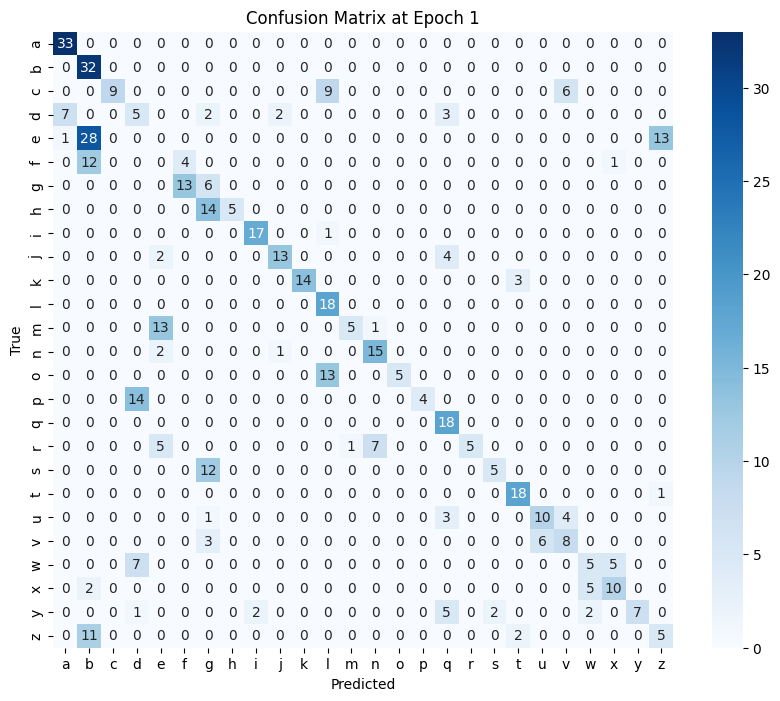

Class a:
True Positives: 33
False Positives: 8
False Negatives: 0
True Negatives: 487
---
Class b:
True Positives: 32
False Positives: 53
False Negatives: 0
True Negatives: 443
---
Class c:
True Positives: 9
False Positives: 0
False Negatives: 15
True Negatives: 504
---
Class d:
True Positives: 5
False Positives: 22
False Negatives: 14
True Negatives: 487
---
Class e:
True Positives: 0
False Positives: 22
False Negatives: 42
True Negatives: 464
---
Class f:
True Positives: 4
False Positives: 13
False Negatives: 13
True Negatives: 498
---
Class g:
True Positives: 6
False Positives: 32
False Negatives: 13
True Negatives: 477
---
Class h:
True Positives: 5
False Positives: 0
False Negatives: 14
True Negatives: 509
---
Class i:
True Positives: 17
False Positives: 2
False Negatives: 1
True Negatives: 508
---
Class j:
True Positives: 13
False Positives: 3
False Negatives: 6
True Negatives: 506
---
Class k:
True Positives: 14
False Positives: 0
False Negatives: 3
True Negatives: 511
---
Class

In [69]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1,
    steps_per_epoch=len(train_dataset),
    validation_steps=len(val_dataset),
    callbacks=[epoch_end_callback, print_loss_callback, checkpoint_callback]
)


In [66]:
# Save the final model
final_model_path = '/content/drive/My Drive/Colab Notebooks/ISLtoText/final_model.keras'
model.save(final_model_path)

In [67]:
# Save the last epoch information
with open('epoch_info.json', 'w') as f:
    json.dump({'last_epoch': history.epoch[-1]}, f)

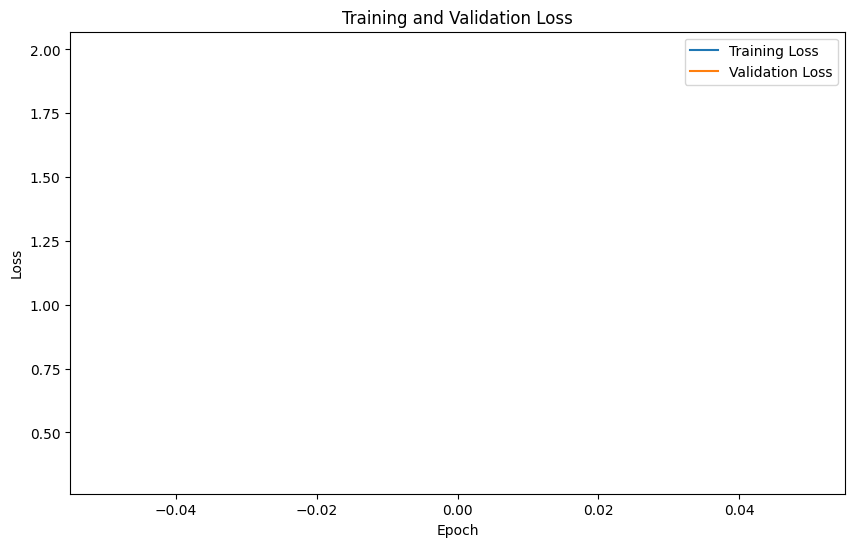

In [68]:
from matplotlib import pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Assuming your validation dataset is val_dataset and your model is loaded as model

# Get true labels and predicted labels
true_labels = []
predicted_labels = []

for images, labels in val_dataset:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(np.argmax(labels, axis=1))

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

KeyboardInterrupt: 

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)


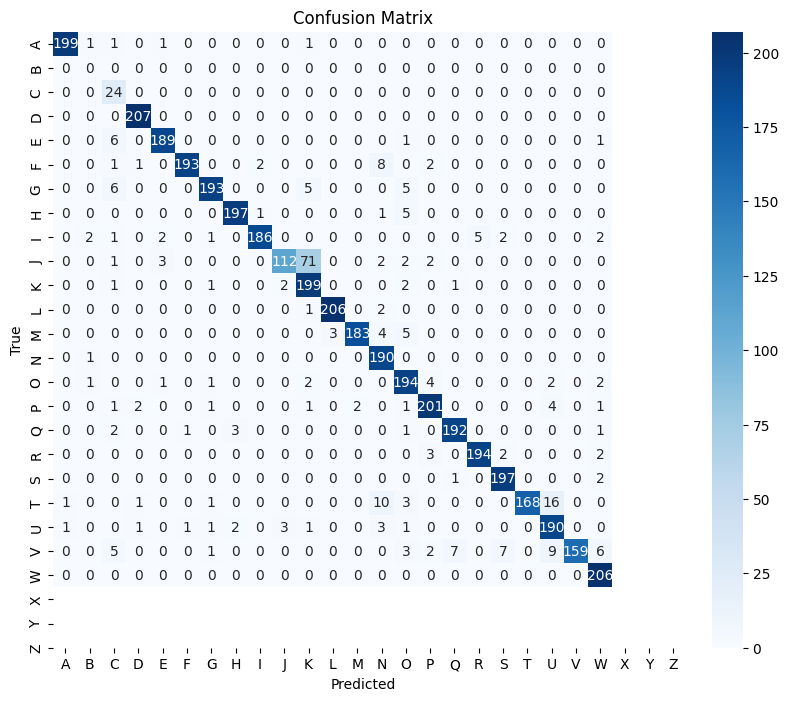

In [ ]:
# Plot the confusion matrix
# Load the class names
class_names = [chr(i) for i in range(65, 91)]  # A-Z
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
